# Credit Card Fraud Detection

## Contents

### [1. Introduction](#intro)

### [2. Data Preparation](#data)
   * **Import the required libraries**
   * **Download and unzip the dataset**
   * **Split the dataset**
   
### [3. Exploratory Analysis](#explore)

### [4. Model Architecture](#cnn)
   * **Set hyperparameters**
   * **Define the model**
   * **Set optimizer** 
   * **Compile model**
   * **Train model**

### [5. Model Evaluation](#eval)
   * **Training Accuracy vs Validation Accuracy**
   * **Training Loss vs Validation Loss**
   * **Model Accuracy**
   * **Observations**

### [6. Prediction](#predict)

### [7. Save Model to Disk](#save)
  

<a id="intro"></a>
### 1. Introduction

#### About the dataset
The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning.

#### Problem statement
Classify the transactions as **fraud (1)** and **legitimate (0)**.

#### Dataset link: https://www.kaggle.com/mlg-ulb/creditcardfraud/

<a id="data"></a>
### 2. Data Preparation

#### Import the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

In [2]:
import keras
from keras import backend as k
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

Using TensorFlow backend.


#### Download and unzip the dataset

### To download data directly directly to this notebook follow the instructions given below:

#### Initially install kaggle by typing            pip  install kaggle         in command line.

### Api Credentials

#### To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (https://www.kaggle.com/<username>/account) and select 'Create API Token'. This will trigger the download of kaggle.json, a file containing your API credentials. Place this file in the location ~/.kaggle/kaggle.json (on Windows in the location C:\Users\<Windows-username>\.kaggle\kaggle.json - you can check the exact location, sans drive, with echo %HOMEPATH%). You can define a shell environment variable KAGGLE_CONFIG_DIR to change this location to $KAGGLE_CONFIG_DIR/kaggle.json (on Windows it will be %KAGGLE_CONFIG_DIR%\kaggle.json).


### for more information refer to   https://github.com/Kaggle/kaggle-api

In [3]:
!kaggle datasets download mlg-ulb/creditcardfraud -f creditcard.csv

100%|███████████████████████████████████████| 66.0M/66.0M [01:03<00:00, 661kB/s]
100%|██████████████████████████████████████| 66.0M/66.0M [01:03<00:00, 1.09MB/s]


In [4]:
my_zipfile = '310%2F23498%2Fcompressed%2Fcreditcard.csv.zip'

In [5]:
import zipfile
with zipfile.ZipFile(my_zipfile, 'r') as zip_ref:
    zip_ref.extractall('')

In [6]:
df  = pd.read_csv('creditcard.csv')

In [7]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<a id="explore"></a>
### 3. Exploratory Analysis

In [8]:
# Datset shape
df.shape

(284807, 31)

In [9]:
# let's check what different classes are present in our dataset

df['Class'].unique()

array([0, 1])

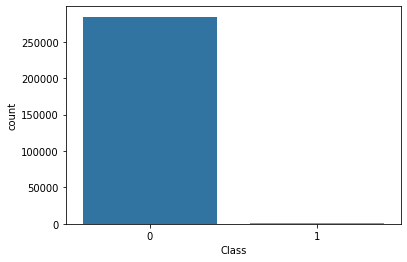

In [10]:
_ = sns.countplot(x='Class',data=df)

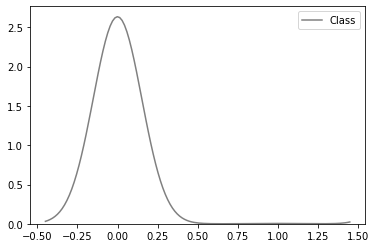

In [11]:
fig, ax = plt.subplots()
_ = sns.kdeplot(df['Class'] , color='gray',bw=0.15)

In [12]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### In above description table we can see that in case of Time and Amount columns the standard deviation, range, magnitude is very large, we need to scale those two columns

In [13]:
scaler = MinMaxScaler()

In [14]:
df['Amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))

### from kdeplot and barplot, one can easily see how this dataset is heavily imbalance ! The representation of non-fraudlent class is far more than fraudlent class. Their representation should be made almost equal , otherwise we would have an accuracy paradox !


-----------------------------------------------------


### Split the dataset


------------------------------------------------------

In [15]:
#what are the representation of each class in dataset, checking numbers

fraudlent_df = df[df['Class']==1]
non_fraudlent_df = df[df['Class']==0]

num_fraudlent_df = len(df[df['Class']==1])
num_non_fraudlent_df = len(df[df['Class']==0])

print(f'number of fraudlent transaction : {num_fraudlent_df}')
print(f'number of non- fraudlent transaction : {num_non_fraudlent_df}')

number of fraudlent transaction : 492
number of non- fraudlent transaction : 284315


#### our main aim here is to take equal representaion of Class 0 and Class 1 in our dataset to minimize data imabalance . I am taking almost 80% of 492 fraudlent transaction in train set.

In [16]:
train_fraudlent_df = resample(fraudlent_df, 
                                 replace=False,    # sample without replacement
                                 n_samples=num_fraudlent_df-100,     #  taking 392 out of 492 in train , 80%
                                 random_state=123) # reproducible results

In [17]:
train_non_fraudlent_df = resample(non_fraudlent_df, 
                                 replace=False,    # sample without replacement
                                 n_samples=num_fraudlent_df-100,     # to match minority class, taking 392 out of 284315 in train
                                 random_state=123) # reproducible results

In [18]:
train_non_fraudlent_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
143480,0.494120,-1.337885,0.261692,2.646536,-1.973014,-0.933318,-1.123839,0.277759,-0.039386,1.111226,...,0.332076,1.124621,-0.312253,0.968527,0.570910,-0.704900,0.253527,0.169347,0.002827,0
163666,0.672120,2.081591,-0.774080,-0.674991,-0.322871,-0.890005,-0.801469,-0.532596,-0.280944,-0.354142,...,-0.329597,-0.310603,0.268725,0.020092,-0.359343,0.555034,-0.025385,-0.044868,0.001374,0
137005,0.474420,-0.332971,1.188389,1.308248,0.052384,0.087272,-0.966515,0.750302,-0.108085,-0.488491,...,-0.258700,-0.638700,-0.029226,0.346024,-0.140051,0.070181,0.250678,0.099306,0.000039,0
155649,0.613495,-0.830622,1.222904,1.859594,-0.318554,0.272904,0.080357,0.385614,-0.167806,1.502836,...,-0.242243,-0.528849,-0.360037,-0.740677,0.367026,-0.700618,-0.323105,0.064605,0.000083,0
219246,0.819772,1.964854,0.306862,-2.347355,1.144732,1.453977,-0.144400,0.871268,-0.209065,-0.308091,...,0.392735,1.461507,-0.126488,-0.910153,0.646694,-0.101542,0.000524,-0.089904,0.000039,0


In [19]:
train_fraudlent_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
108258,0.409903,0.196707,1.189757,0.704882,2.891388,0.045555,1.245730,-1.198714,-2.421616,-1.232089,...,-1.328132,0.189311,-0.005524,-0.814708,0.400924,0.286281,0.135215,0.257315,0.000030,1
15810,0.157716,-25.942434,14.601998,-27.368650,6.378395,-19.104033,-4.684806,-18.261393,17.052566,-3.742605,...,1.784316,-1.917759,-1.235787,0.161105,1.820378,-0.219359,1.388786,0.406810,0.003892,1
144108,0.496939,-3.586964,2.609127,-5.568577,3.631947,-4.543590,-0.157899,-4.089128,2.417305,-3.239901,...,1.024423,0.428756,0.182032,-0.534598,0.168933,-0.149844,0.685517,-0.299728,0.012083,1
154371,0.586329,-25.825982,19.167239,-25.390229,11.125435,-16.682644,3.933699,-37.060311,-28.759799,-11.126624,...,-16.922016,5.703684,3.510019,0.054330,-0.671983,-0.209431,-4.950022,-0.448413,0.000089,1
80760,0.339379,-0.451383,2.225147,-4.953050,4.342228,-3.656190,-0.020121,-5.407554,-0.748436,-1.362198,...,-0.575924,0.495889,1.154128,-0.016186,-2.079928,-0.554377,0.455179,0.001321,0.004434,1


In [20]:
train_non_fraudlent_df.shape

(392, 31)

In [21]:
train_fraudlent_df.shape

(392, 31)

In [22]:
train_df = pd.concat([train_non_fraudlent_df, train_fraudlent_df]) # final training set

In [23]:
train_df = train_df.sample(frac=1)   # shuffling the whole train dataframe

In [24]:
train_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
52521,0.263328,1.001992,0.047938,-0.349002,1.493958,0.186939,0.190966,-0.001112,0.147140,0.580415,...,-0.334417,-1.014315,-0.128427,-0.946242,0.456090,-0.453206,0.046627,0.064698,4.125544e-03,1
77348,0.329917,-1.271244,2.462675,-2.851395,2.324480,-1.372245,-0.948196,-3.065234,1.166927,-2.268771,...,0.652941,0.081931,-0.221348,-0.523582,0.224228,0.756335,0.632800,0.250187,3.892389e-07,1
102444,0.394735,-13.192671,12.785971,-9.906650,3.320337,-4.801176,5.760059,-18.750889,-37.353443,-0.391540,...,27.202839,-8.887017,5.303607,-0.639435,0.263203,-0.108877,1.269566,0.939407,3.892389e-05,1
154985,0.601382,-0.584354,1.687656,-0.824543,0.462724,1.965918,-1.426432,2.164792,-1.266514,0.982610,...,0.082398,0.766984,-0.224897,-0.230704,-0.451234,-0.753287,-0.934028,-0.140684,3.853466e-04,0
117957,0.433400,1.219661,1.121000,-2.157328,1.545964,1.751149,0.332003,0.182626,0.222810,-0.020855,...,-0.440100,-1.003212,-0.357910,-2.117555,0.863884,-0.219413,0.093550,0.095178,3.892389e-05,0


In [25]:
train_df_index = train_df.index

In [26]:
df.drop(train_df_index, inplace=True ) # after dropping the rows from train dataframe , the remaining will be used for testing

In [27]:
train_df.reset_index(drop=True, inplace=True)

In [28]:
df.reset_index(drop=True, inplace=True)

#### training set

In [29]:
x_train = train_df.values[:,:-1]

In [30]:
y_train = train_df.values[:,-1]

In [31]:
x_train.shape

(784, 30)

In [32]:
y_train.shape

(784,)

#### test set

In [33]:
x_test = df.values[:,:-1]

In [34]:
y_test  = df.values[:,-1]

In [35]:
x_test.shape

(284023, 30)

In [36]:
y_test.shape

(284023,)

-----------------------------------------------------------------------------------------------------------------


#### some basic ML model testing, before making  a neural net 


-----------------------------------------------------------------------------------------------------------------

### knn

In [37]:
knn_model = KNeighborsClassifier()
knn_model.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [38]:
predictions_knn = knn_model.predict(x_test)

In [39]:
knn_model.score(x_test,y_test)

0.9770159458917059

### lr

In [40]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
predictions_log = logreg.predict(x_test)

In [42]:
logreg.score(x_test,y_test)

0.9753646711709967

### DecisionTree

In [43]:
dec_tree = DecisionTreeClassifier(random_state=0)
dec_tree.fit(x_train, y_train)
predictions_dt = dec_tree.predict(x_test)

In [44]:
dec_tree.score(x_test,y_test)

0.8970681951813761

### Random Forrest

In [45]:
ran_for = RandomForestClassifier(random_state=0)
ran_for.fit(x_train, y_train)
predictions_rf = ran_for.predict(x_test)

In [46]:
ran_for.score(x_test,y_test)

0.980015702953634

### Gradient Boost

In [47]:
gb = GradientBoostingClassifier(random_state=0)
gb.fit(x_train, y_train)
predictions_gb = gb.predict(x_test)

In [48]:
gb.score(x_test,y_test)

0.9622248902377625

In [49]:
prediction_list = [predictions_knn, predictions_log,  predictions_dt, predictions_rf, predictions_gb ]
name = ['KNN','LOGISTIC REGRESSION', 'DECISION TREE', 'RANDOM FORREST', 'GRADIENT BOOST']  

In [50]:
def plot_confusion_matrix(cm,classes,normalize=False,
                          title='confusion_matrix',cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=30)
    plt.yticks(tick_marks,classes)
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('confusion  matrix without normalization')
    print(cm)
    
    thresh = cm.max()/2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                 horizontalalignment='center',
                 color='white' if cm[i,j]>thresh else "black")
    plt.tight_layout()
    plt.ylabel('true label')

    plt.xlabel('predicted label')

confusion  matrix without normalization
[[277406   6517]
 [    11     89]]
confusion  matrix without normalization
[[276935   6988]
 [     9     91]]
confusion  matrix without normalization
[[254698  29225]
 [    10     90]]
confusion  matrix without normalization
[[278257   5666]
 [    10     90]]
confusion  matrix without normalization
[[273205  10718]
 [    11     89]]


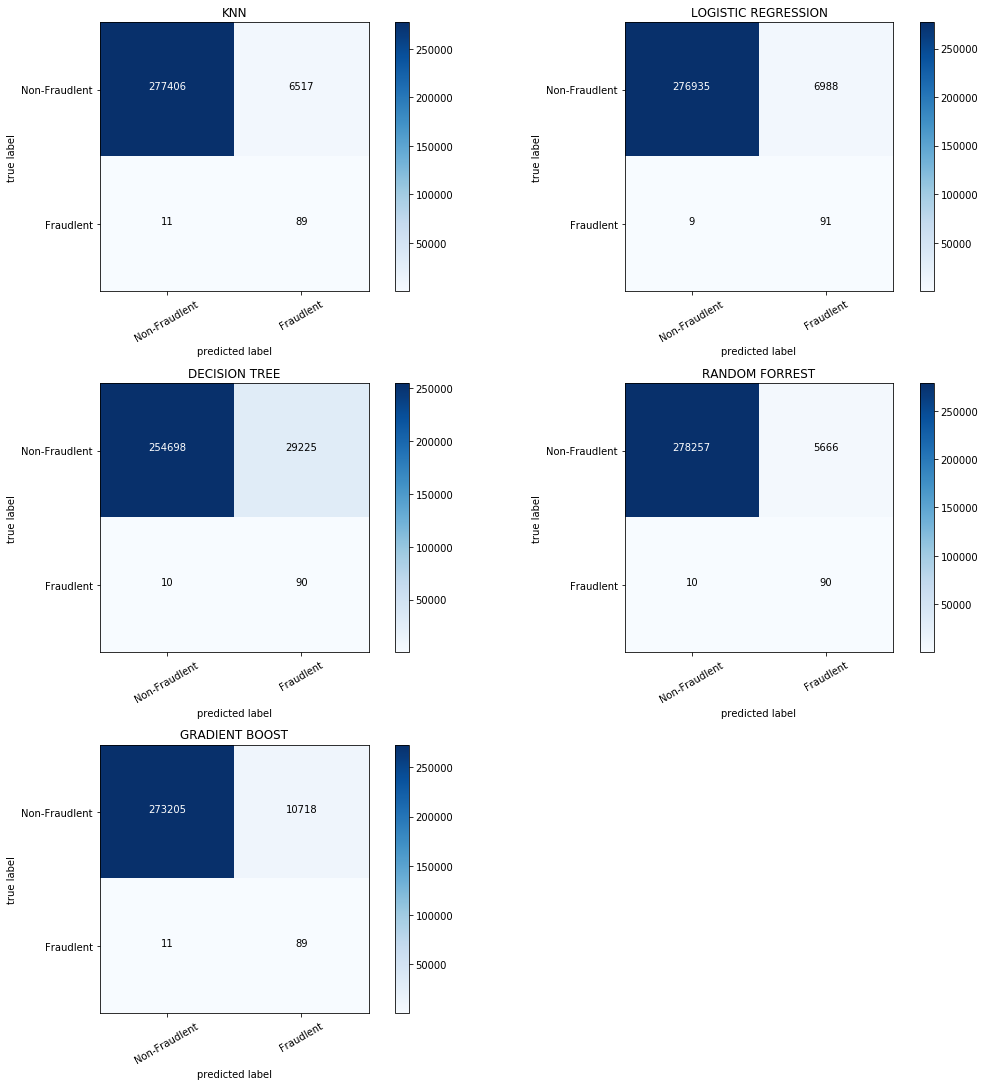

In [51]:
plt.figure(figsize=(15,15))
for i in range(5):
    plt.subplot(3,2,i+1)
    cm = confusion_matrix(y_test, prediction_list[i])
    cm_plot_labels = ['Non-Fraudlent', 'Fraudlent']
    _ = plot_confusion_matrix(cm,cm_plot_labels,title=f'{name[i]}')

<a id="cnn"></a>
### 4. Model Architecture

#### Set hyperparameters

In [52]:
activation_fn           = 'relu'
num_hidden_unit_layer_1 = 30
num_hidden_unit_layer_2 = 32
num_output_unit         = 2
num_epoch               = 20
batch_size              = 10
learning_rate           = 0.001

#### Define the model

In [53]:
nn=Sequential([
    Dense(30, input_shape=(30,), activation=activation_fn),
    Dense(32, activation=activation_fn),
    Dense(num_output_unit, activation='softmax')
])

In [54]:
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


#### Set optimizer 

In [55]:
optimizer = Adam(lr=learning_rate)

#### Compile model

In [56]:
nn.compile(optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#### Train model

In [57]:
history =nn.fit(x_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=num_epoch, shuffle=True, verbose=2)

Train on 627 samples, validate on 157 samples
Epoch 1/20
 - 1s - loss: 0.3662 - accuracy: 0.8278 - val_loss: 0.2298 - val_accuracy: 0.9363
Epoch 2/20
 - 0s - loss: 0.2035 - accuracy: 0.9346 - val_loss: 0.1751 - val_accuracy: 0.9490
Epoch 3/20
 - 0s - loss: 0.1617 - accuracy: 0.9394 - val_loss: 0.1591 - val_accuracy: 0.9490
Epoch 4/20
 - 0s - loss: 0.1398 - accuracy: 0.9426 - val_loss: 0.1518 - val_accuracy: 0.9490
Epoch 5/20
 - 0s - loss: 0.1247 - accuracy: 0.9490 - val_loss: 0.1492 - val_accuracy: 0.9490
Epoch 6/20
 - 0s - loss: 0.1142 - accuracy: 0.9537 - val_loss: 0.1426 - val_accuracy: 0.9490
Epoch 7/20
 - 1s - loss: 0.1018 - accuracy: 0.9649 - val_loss: 0.1397 - val_accuracy: 0.9490
Epoch 8/20
 - 0s - loss: 0.0948 - accuracy: 0.9633 - val_loss: 0.1376 - val_accuracy: 0.9490
Epoch 9/20
 - 0s - loss: 0.0884 - accuracy: 0.9665 - val_loss: 0.1388 - val_accuracy: 0.9554
Epoch 10/20
 - 1s - loss: 0.0807 - accuracy: 0.9713 - val_loss: 0.1327 - val_accuracy: 0.9554
Epoch 11/20
 - 0s - los

<a id="eval"></a>
### 5. Model Evaluation

#### Training Accuracy vs Validation Accuracy

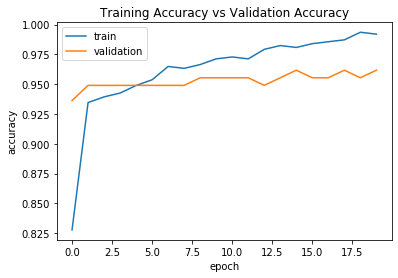

In [58]:
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


#### Training Loss vs Validation Loss

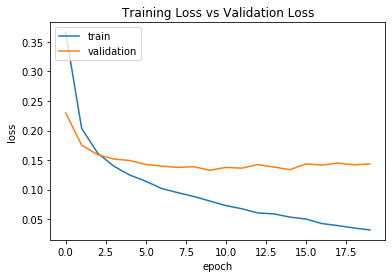

In [59]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


#### Model Accuracy

In [60]:
score, acc = nn.evaluate(x_test, y_test,batch_size=100)

284023/284023 [==============================] - 9s 31us/step


In [61]:
print(f'Test Score   : {score}')
print(f'Test Accuracy:   {acc}')

Test Score   : 0.13977243510878712
Test Accuracy:   0.9575949907302856


#### Observations:

96%  test accuracy is a decent value .Also, in the test set there was only 100 fraudlent transaction and remaining 283923 are non-fraudlent, so our main purpose will be to see how each label has been classified. It is important to note that if we hadn't done previous imbalance removal we may get an more accurate model , but there all fraudlent transaction would just be considered a noise. So , in that case the error would be more critical. 

<a id="predict"></a>
### 6. Prediction

In [62]:
predict =nn.predict(x_test)

In [63]:
predictions = nn.predict_classes(x_test, batch_size=100, verbose=0)

In [64]:
cm = confusion_matrix(y_test, predictions)

confusion  matrix without normalization
[[271888  12035]
 [     9     91]]


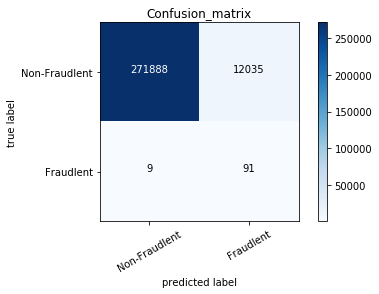

In [65]:
cm_plot_labels = ['Non-Fraudlent', 'Fraudlent']
_ = plot_confusion_matrix(cm,cm_plot_labels,title='Confusion_matrix')

#### From the confusion matrix we can see that the imbalance issue has been properly handled as both the classes has pretty high test accuracy.

<a id="save"></a>
### 7. Save Model to Disk

In [66]:
# nn.save('credit_card_fraud_detection.h5')